# Intro to Easy Ocean

Argovis indexes a representation of [Easy Ocean](https://cchdo.ucsd.edu/products/goship-easyocean) data. In this notebook, we tour basic search options for this dataset. Note that we assume you are already familiar with the basic patterns of Argovis' API; if not, try starting with the [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb) notebook first.

## Setup

In addition to importing a few python packages and declaring a couple of helper functions, make sure to plug in your Argovis API key for `API_KEY` at the bottom of the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import matplotlib.pyplot as plt
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

## Finding and plotting WOCE lines and sections

In order to browse the Easy Ocean WOCE lines, we provide a vocabulary route that summarizes what's available in the database:

In [4]:
vocab_params = {
    "parameter": "woceline" # could also be "cchdo_cruise"
}

wocelines = avh.query('easyocean/vocabulary', options=vocab_params, apikey=API_KEY, apiroot=API_ROOT)
wocelines

['75N',
 'A02',
 'A03',
 'A05',
 'A10',
 'A12',
 'A13',
 'A16-A23',
 'A20',
 'A22',
 'A9.5',
 'AR07E',
 'AR07W',
 'I01',
 'I02',
 'I03-I04',
 'I05',
 'I06S',
 'I07',
 'I08N',
 'I08S-I09N',
 'I09S',
 'I10',
 'IR06-I10',
 'IR06E',
 'IR06',
 'P01',
 'P02',
 'P03',
 'P04',
 'P06',
 'P09',
 'P10',
 'P11',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17E',
 'P17',
 'P18',
 'P21',
 'S04I',
 'S04P',
 'SR01',
 'SR03',
 'SR04']

Perhaps we're interested in A10. We can see all the times the A10 line has been populated in the A10 metadata; Easy Ocean metadata documents corespond to WOCE lines, and have `id` that matches the WOCE line identifier: 

In [13]:
easyocean_meta_params = {
    "woceline": "A10" # or anything from the list above
}

easyocean_meta = avh.query('easyocean/meta', options=easyocean_meta_params, apikey=API_KEY, apiroot=API_ROOT)
easyocean_meta

[{'_id': 'A10',
  'occupancies': [{'varying_direction': 'lon',
    'static_direction': 'lat',
    'expocodes': ['06MT22_5'],
    'time_boundaries': ['1992-12-30T00:00:00.000Z',
     '1993-01-28T00:00:00.000Z']},
   {'varying_direction': 'lon',
    'static_direction': 'lat',
    'expocodes': ['49NZ200311_4'],
    'time_boundaries': ['2003-11-07T00:00:00.000Z',
     '2003-12-02T00:00:00.000Z']},
   {'varying_direction': 'lon',
    'static_direction': 'lat',
    'expocodes': ['33RO20110926'],
    'time_boundaries': ['2011-09-28T00:00:00.000Z',
     '2011-10-29T00:00:00.000Z']}],
  'date_updated_argovis': '2024-01-16T19:20:58.015Z'}]

The `occupancies` key in the A10 metadata indicates that Easy Ocean has 3 traversals of A10; one at the end of 1992, one in late 2003, and one in the autumn of 2011. Perhaps we're interested in the 2011 data; we can request it as follows, by filtering on WOCE line as well as `section_start_date`, which should match the first element in the `time_boundaries` key of the metadata entry of interest:

In [10]:
easyocean_data_params = {
    "woceline": 'A10',
    "section_start_date": '2011-09-28T00:00:00.000Z',
    "data": 'all'
}

easyocean_data_2011 = avh.query('easyocean', options=easyocean_data_params, apikey=API_KEY, apiroot=API_ROOT)

Let's map this data just to make sure it looks like A10:

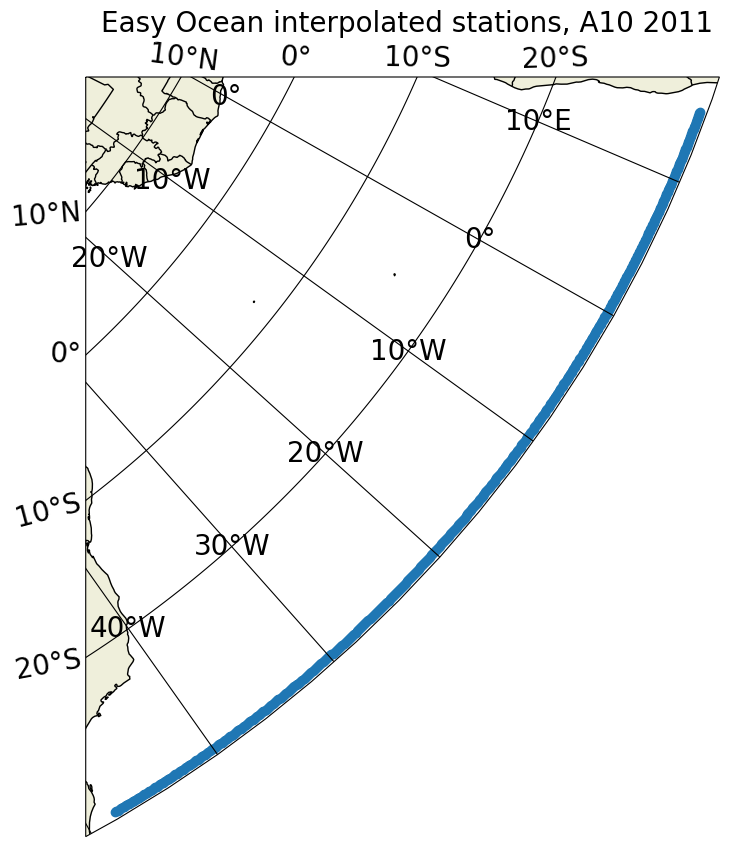

In [15]:
eo_longitudes = [x['geolocation']['coordinates'][0] for x in easyocean_data_2011]
eo_latitudes  = [x['geolocation']['coordinates'][1] for x in easyocean_data_2011]

helpers.simple_map(eo_longitudes, eo_latitudes, title='Easy Ocean interpolated stations, A10 2011')

We may also want to compare interpolated stations and levels across time. Let's first download the 1992 traversal of A10 exactly as we did above: 

In [16]:
easyocean_data_params = {
    "woceline": 'A10',
    "section_start_date": '1992-12-30T00:00:00.000Z',
    "data": 'all'
}

easyocean_data_1992 = avh.query('easyocean', options=easyocean_data_params, apikey=API_KEY, apiroot=API_ROOT)

Let's find two comparable points between these two datasets; Easy Ocean interpolates to standard locations, so we can match by latitude and longitude:

In [32]:
k = None
for i in range(len(easyocean_data_2011)):
    if easyocean_data_2011[i]['geolocation'] == easyocean_data_1992[0]['geolocation']:
        k = i
        
print(easyocean_data_1992[0]['geolocation'])
print(easyocean_data_2011[k]['geolocation'])


{'coordinates': [14.6, -29.57], 'type': 'Point'}
{'coordinates': [14.6, -29.57], 'type': 'Point'}


Next let's check that these two measurements at this location have comparable levels; again, Easy Ocean interpolates to standard levels, but different traversals of A10 might have measured to different depths:

In [37]:
pressure_index_1992 = easyocean_data_1992[0]['data_info'][0].index('pressure')
pressure_index_2011 = easyocean_data_2011[k]['data_info'][0].index('pressure')
print('1992 levels:', easyocean_data_1992[0]['data'][pressure_index_1992])
print('2011 levels:', easyocean_data_2011[k]['data'][pressure_index_2011])

1992 levels: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330]
2011 levels: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]


So we see that the 2011 data cuts off at a shallower depth; we'll just consider the levels common to both years in what follows. Let's slice the conservative temperatures for both years to these common levels and plot their difference:

Text(0, 0.5, 'dbar')

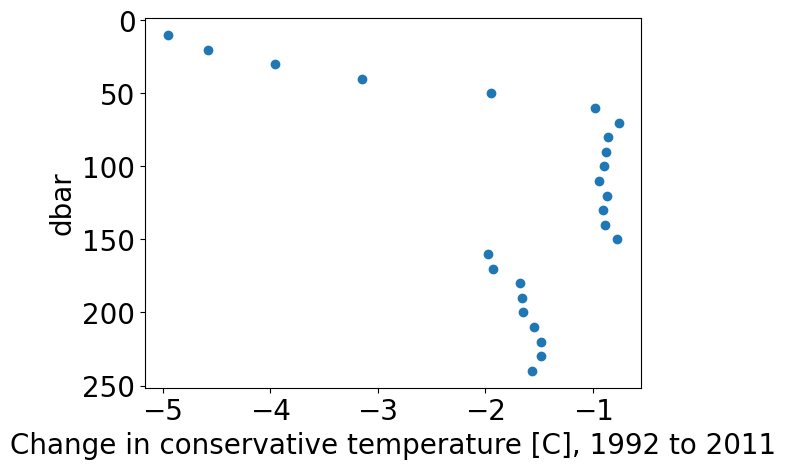

In [47]:
temp_index_1992 = easyocean_data_1992[0]['data_info'][0].index('conservative_temperature')
temp_index_2011 = easyocean_data_2011[k]['data_info'][0].index('conservative_temperature')
temp_1992 = easyocean_data_1992[0]['data'][temp_index_1992]
temp_2011 = easyocean_data_2011[k]['data'][temp_index_2011]
temp_delta = [temp_2011[i] - temp_1992[i] for i in range(len(temp_2011))]

plt.scatter(temp_delta, easyocean_data_2011[k]['data'][pressure_index_2011])
plt.gca().invert_yaxis()
plt.xlabel('Change in conservative temperature [C], 1992 to 2011')
plt.ylabel('dbar')